In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from numba import njit

In [7]:
np.random.seed(42)

In [2]:
# Parameters of the potential
x0=1.0
a0=1.0/3.0
b0=5.0/3.0
u0=5.0
w0=1.0/5.0

@njit
def potential(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 3.0/5.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4)
    return U

@njit
def force(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-((q[0] - x0)**2 + y2))
    e4 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -3.0/5.0*q[0]*e2 - (q[0]-x0)*e3 - (q[0]+x0)*e4)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -3.0/5.0*(q[1] - b0)*e2 - q[1]*e3 - q[1]*e4)-4.0*w0*(q[1] - a0)**3
    return np.array([fx, fy])

@njit
def state(q): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    tmp = q[0]**2 + 1 + q[1]**2
    if tmp - 2*q[0] < 1.0:
        U = potential(q)
        if U <-2.4:  # Product state
            state = 1
    if tmp + 2*q[0] < 1.0:
        U = potential(q)
        if U <-2.4:  # Reactant state
            state = -1
    return state

@njit
def z_dist(q):
    return np.sqrt((q[0] - 1)**2 + q[1]**2) # Distance from the center of the product state

## Langevin equation in potential well

In [3]:
@njit
def LI(q0, dt = 0.02, KbT = 0.15, isteps = 4000):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        i += 1
        s = state(q[i,:])
        #print('State:= ', s)
        #print('Position:= ',q[i,:])
        #print('Trajectory length:= ', i-j-2)
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        return out
        
    return q[j+1:i-1,:]

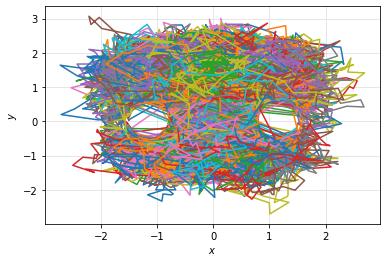

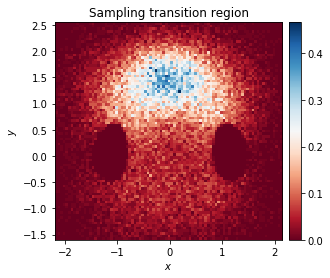

In [4]:
# Fix the temperature
KbT = 1.5
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    # I set a random seed if not stated otherwise
    q0 = np.array([-1.0, 0.0])
    traj = LI(q0, KbT = KbT)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1])
        if tmp==0:
            trajall = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.6, 2.6, 0.05).tolist()
else:
    xedges = np.arange(-1.5, 1.5, 0.05).tolist()
    yedges = np.arange(-0.5, 1.6, 0.05).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

# Steered Langevin

In [5]:
@njit
def LI_S(q0, dt = 0.02, KbT = 0.15, ks = 1, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])   
        z = z_dist(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*(q[i,0]-1.0)*dt/z
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*q[i,1]*dt/z
        i += 1
        s = state(q[i,:])
        #print('State:= ', s)
        #print('Position:= ',q[i,:])
        #print('Trajectory length:= ', i-j-2)
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        return out
        
    return q[j+1:i-1,:]

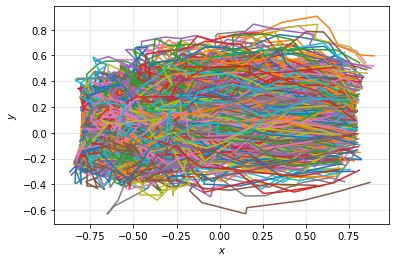

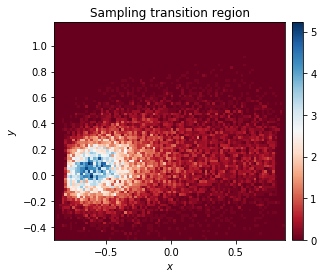

In [6]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
np.random.seed(42)
for i in range(1000):
    q0 = np.array([-1.0, 0.0])
    traj = LI_S(q0, KbT = KbT, ks = 7)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1])
        if tmp==0:
            trajall = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
    del traj
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-0.9, 0.9, 0.02).tolist()
    yedges = np.arange(-0.5, 1.2, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

# Langevin RMD

In [8]:
@njit
def LI_RMD(q0, dt = 0.02, KbT = 0.15, kr = 1, seed=None,  isteps = 4000):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    z = np.empty(isteps, dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmin = z_dist(q[0,:])
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        z[i] = z_dist(q[i,:])
        if z[i] < zmin:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            zmin = z[i]
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*(q[i,0]-1.0)*dt/z[i]
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*q[i,1]*dt/z[i]
        i += 1
        s = state(q[i,:])
        #print('State:= ', s)
        #print('Position:= ',q[i,:])
        #print('Trajectory length:= ', i-j-2)
        
    z[i] = z_dist(q[i,:])
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outz = np.empty(1, dtype=np.float64)
        outz[0] = 0.0
        return out, z
        
    return q[j+1:i-1,:], z[j+1:i-1]

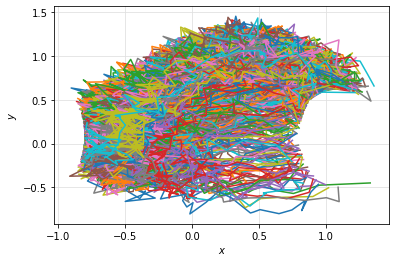

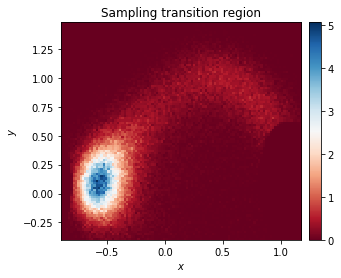

In [9]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
np.random.seed(42)
for i in range(1000):
    q0 = np.array([-1.0, 0.0])
    traj, z = LI_RMD(q0, KbT = KbT, kr = 50)
    plt.plot(traj[:,0], traj[:,1])
    #plt.plot(z)
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    del traj
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-0.9, 1.2, 0.02).tolist()
    yedges = np.arange(-0.4, 1.5, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()